In [89]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn import tree
from sklearn.svm import SVC
from sklearn import neighbors as nbhs
from sklearn.model_selection import cross_val_predict
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import naive_bayes
from tensorflow import keras

#Importing
train=pd.read_csv("train.csv")

#Assigning int value to string value in Embarked and Sex
E = {'Embarked':{'C': 0, 'Q': 1, 'S': 2},'Sex': {'male':0,'female':1}}
train.replace(E, inplace = True)

#Dropping columns
train = train.drop(['PassengerId','Cabin','Name','Ticket'], axis=1)

#adding median value of the age in place of missing values
q = train.loc[:,"Age"].median()
train = train.fillna({'Age': q})


train['Embarked'] = train['Embarked'].fillna(2)
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null float64
dtypes: float64(3), int64(5)
memory usage: 55.8 KB


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0


In [90]:
from sklearn.model_selection import train_test_split
X = train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]     
Y = train['Survived']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


In [91]:
profit = [[-100 , -500],[-10 , -10]]
TNp = profit[0][0]
FNp = profit[1][0] 
FPp = profit[0][1] 
TPp = profit[1][1] 

#True probabilities:
pp = 1/2
pn = 1/2

In [92]:
def rates(TP,FP,FN,TN):
    return TP/(TP + FN), FP/(FP + TN), FN/(FN + TP), TN/(TN + FP)

def curves(model,X_test,Y_test):
    scores = model.predict_proba(X_test)
    if scores.shape[1] > 1:
        scores = scores[:,1]
    Y_test = Y_test.to_numpy()
    scoreY = [(scores[k] , Y_test[k]) for k in range(len(Y_test))]
    scoreY.sort(key=(lambda x: x[0]),reverse=True)
    
    Profit = np.zeros(len(Y_test)+1)
    CumResp = np.zeros(len(Y_test)+1)
    Lift = np.zeros(len(Y_test)+1)
    ROC = np.zeros((len(Y_test)+1,2))
    AUC = 0
    x0 = 0
    
    TP, FP, FN, TN = 0, 0, sum(Y_test == True), sum(Y_test == False)
    TPR, FPR, FNR, TNR = rates(TP,FP,FN,TN)
    Profit[0] = pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)
    CumResp[0] = 0
    Lift[0] = 1
    ROC[0,:] = FPR, TPR
    if FPR > x0:
        AUC += TPR*(FPR-x0)
        x0 = FPR
    
    for k in range(len(Y_test)):
        if scoreY[k][1]:
            TP = TP + 1
            FN = FN - 1
        else:
            FP = FP + 1
            TN = TN - 1
        TPR, FPR, FNR, TNR = rates(TP,FP,FN,TN)
        kk = k+1
        Profit[kk] = pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)
        CumResp[kk] = TPR
        Lift[kk] = TPR/(kk/len(Y_test))
        ROC[kk,:] = FPR, TPR
        if FPR > x0:
            AUC += TPR*(FPR-x0)
            x0 = FPR
    AUC += 1-x0
    return Profit, CumResp, Lift, ROC, AUC


x = range(len(Y_test)+1)
x = [x[k]/len(Y_test) for k in range(len(x))]

def plot_curves(Profit, Cumulative, Lift, ROC, curve_type):
    #Profit Curves
    plt.figure()
    plt.plot([0,1],[nbcProfit[0],nbcProfit[-1]])
    plt.plot(x,Profit)
    plt.legend(("Random", curve_type))
    plt.title("Profit Curve")
    plt.xlabel("% Data")
    plt.ylabel("Profit ($)")

    #Cumulative Response Curves
    plt.figure()
    plt.plot([0,1],[0,1])
    plt.plot(x,Cumulative)
    plt.legend(("Random", curve_type))
    plt.title("Cumulative Response Curve")
    plt.xlabel("% Data")
    plt.ylabel("TPR")

    #Lift Curves
    plt.figure()
    plt.plot(x,np.ones(len(x)))
    plt.plot(x,Lift)
    plt.legend(("Random", curve_type))
    plt.title("Lift Curve")
    plt.xlabel("% Data")
    plt.ylabel("Lift")

    #ROC Curves
    plt.figure()
    plt.plot([0,1],[0,1])
    plt.plot(ROC[:,0],ROC[:,1])
    plt.legend(("Random", curve_type))
    plt.title("ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")

In [93]:
#Curves for KNN
def rates(TP,FP,FN,TN):
    return TP/(TP + FN), FP/(FP + TN), FN/(FN + TP), TN/(TN + FP)

def curves_knn(model,X_test,Y_test):
    scores = model.predict_proba(X_test)
    if scores.shape[1] > 1:
        scores = scores[:,1]
    Y_test = Y_test.to_numpy()
    scoreY = [(scores[k] , Y_test[k]) for k in range(len(Y_test))]
    scoreY.sort(key=(lambda x: x[0]),reverse=True)
    
    Profit = np.zeros(len(Y_test)+1)
    CumResp = np.zeros(len(Y_test)+1)
    Lift = np.zeros(len(Y_test)+1)
    AUC = 0
    x0 = 0
    
    TP, FP, FN, TN = 0, 0, sum(Y_test == True), sum(Y_test == False)
    TPR, FPR, FNR, TNR = rates(TP,FP,FN,TN)
    Profit[0] = pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)
    CumResp[0] = 0
    Lift[0] = 1
    if FPR > x0:
        AUC += TPR*(FPR-x0)
        x0 = FPR
    
    for k in range(len(Y_test)):
        if scoreY[k][1]:
            TP = TP + 1
            FN = FN - 1
        else:
            FP = FP + 1
            TN = TN - 1
        TPR, FPR, FNR, TNR = rates(TP,FP,FN,TN)
        kk = k+1
        Profit[kk] = pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)
        CumResp[kk] = TPR
        Lift[kk] = TPR/(kk/len(Y_test))
        if FPR > x0:
            AUC += TPR*(FPR-x0)
            x0 = FPR
    AUC += 1-x0
    return Profit, CumResp, Lift, AUC


x = range(len(Y_test)+1)
x = [x[k]/len(Y_test) for k in range(len(x))]

def plot_curves_knn(Profit, Cumulative, Lift, curve_type):
    #Profit Curves
    plt.figure()
    plt.plot([0,1],[nbcProfit[0],nbcProfit[-1]])
    plt.plot(x,Profit)
    plt.legend(("Random", curve_type))
    plt.title("Profit Curve")
    plt.xlabel("% Data")
    plt.ylabel("Profit ($)")

    #Cumulative Response Curves
    plt.figure()
    plt.plot([0,1],[0,1])
    plt.plot(x,Cumulative)
    plt.legend(("Random", curve_type))
    plt.title("Cumulative Response Curve")
    plt.xlabel("% Data")
    plt.ylabel("TPR")

    #Lift Curves
    plt.figure()
    plt.plot(x,np.ones(len(x)))
    plt.plot(x,Lift)
    plt.legend(("Random", curve_type))
    plt.title("Lift Curve")
    plt.xlabel("% Data")
    plt.ylabel("Lift")


[[99 15]
 [15 50]]
Expected profit on THIS dataset: -25.35112359550562
Expected profit for comparison: -81.31578947368422
nbcAUC: 0.8906882591093124


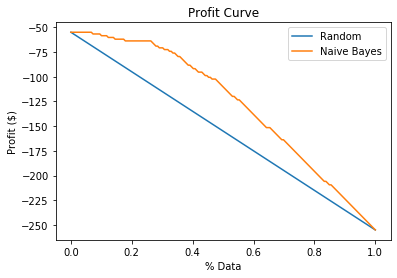

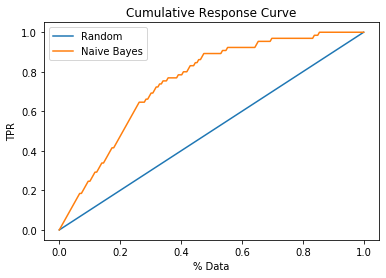

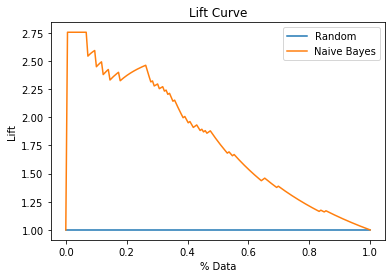

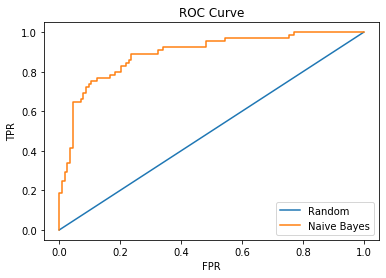

In [94]:
#Naive Bayes
nbc = naive_bayes.GaussianNB()
nbc.fit(X_train,np.ravel(Y_train))
conf = confusion_matrix(nbc.predict(X_test), Y_test)
print(conf)
TN, FN, FP, TP = conf.ravel()
print(f"Expected profit on THIS dataset: {np.sum(conf*profit)/len(Y_train)}")

TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
TNR = TN/(TN + FP)
print(f"Expected profit for comparison: {pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)}")
nbcProfit, nbcCumResp, nbcLift, nbcROC, nbcAUC = curves(nbc,X_test,Y_test)
print("nbcAUC: " + str(nbcAUC))

plot_curves(nbcProfit, nbcCumResp, nbcLift, nbcROC, "Naive Bayes")

[[101  18]
 [ 13  47]]
Expected profit on THIS dataset: -27.668539325842698
Expected profit for comparison: -77.80701754385964
logregAUC: 0.8923076923076924


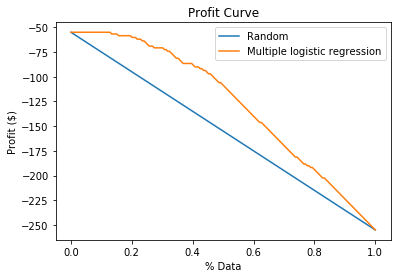

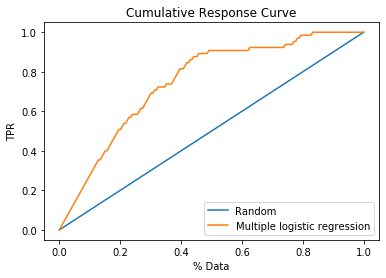

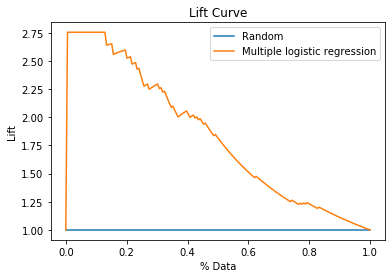

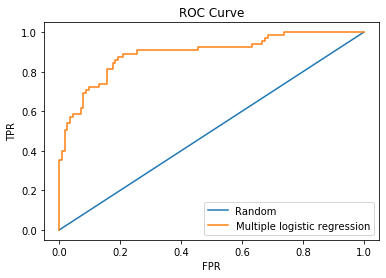

In [95]:
#Logistic Regression
log = LogisticRegression(solver='liblinear')
log.fit(X_train, np.ravel(Y_train))

CMnorm = confusion_matrix(log.predict(X_test), Y_test)
print(CMnorm)
TN, FN, FP, TP = CMnorm.ravel()
print(f"Expected profit on THIS dataset: {np.sum(CMnorm*profit)/len(Y_train)}")

TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
TNR = TN/(TN + FP)
print(f"Expected profit for comparison: {pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)}")
logProfit, logCumResp, logLift, logROC, logAUC = curves(log,X_test,Y_test)
print("logregAUC: " + str(logAUC))

plot_curves(logProfit, logCumResp, logLift, logROC, "Multiple logistic regression")

[[98 17]
 [16 48]]
Expected profit on THIS dataset: {np.sum(conf*profit)/len(Y_train)}
Expected profit for comparison: {pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)}
svclAUC: 0.8777327935222679


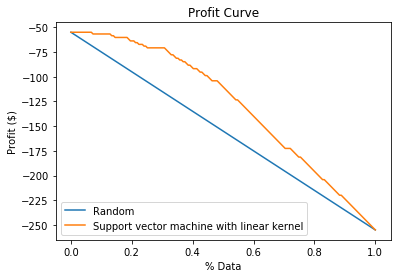

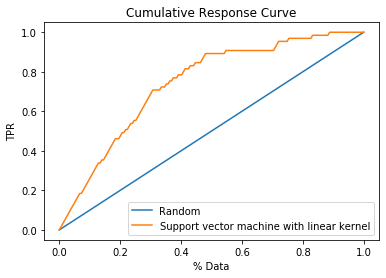

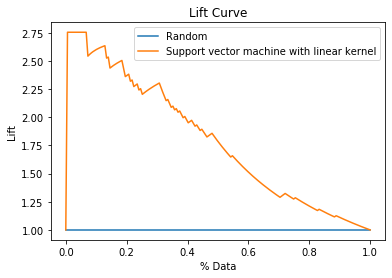

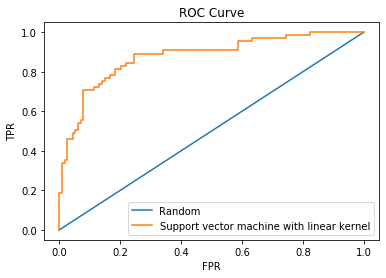

In [96]:
#SVC Linear
svc = svm.SVC(kernel='linear', probability = True)
svc.fit(X_train,np.ravel(Y_train))
conf = confusion_matrix(svc.predict(X_test), Y_test)
print(conf)
TN, FN, FP, TP = conf.ravel()
print("Expected profit on THIS dataset: {np.sum(conf*profit)/len(Y_train)}")

TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
TNR = TN/(TN + FP)
print("Expected profit for comparison: {pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)}")
svcProfit, svcCumResp, svcLift, svcROC, svcAUC = curves(svc,X_test,Y_test)
print("svclAUC: " + str(svcAUC))
plot_curves(svcProfit, svcCumResp, svcLift, svcROC, "Support vector machine with linear kernel")

[[93 28]
 [21 37]]
Expected profit on THIS dataset: {np.sum(CONF*profit)/len(Y_train)}
Expected profit for comparison: {pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)}
svc_rbfAUC: 0.7848852901484481


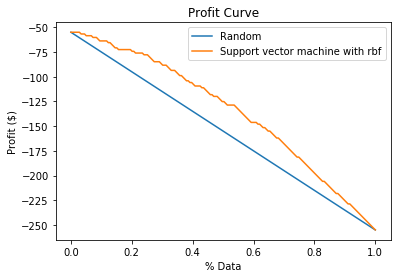

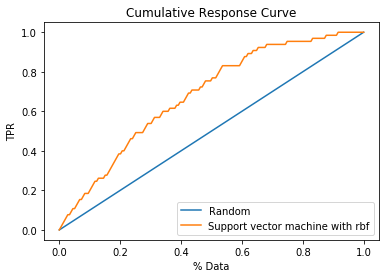

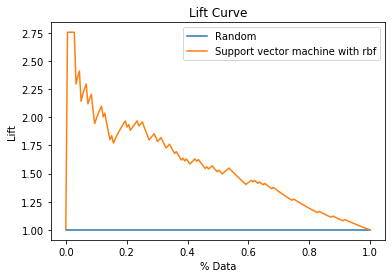

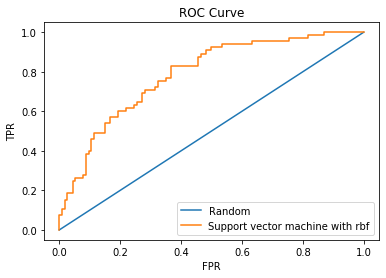

In [97]:
#SVC RBF
svc_rbf = svm.SVC(kernel='rbf',gamma='auto', probability = True)
svc_rbf.fit(X_train,np.ravel(Y_train))
CONF = confusion_matrix(svc_rbf.predict(X_test), Y_test)
print(CONF)
TN, FN, FP, TP = CONF.ravel()
print("Expected profit on THIS dataset: {np.sum(CONF*profit)/len(Y_train)}")

TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
TNR = TN/(TN + FP)
print("Expected profit for comparison: {pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)}")
svc_rbfProfit, svc_rbfCumResp, svc_rbfLift, svc_rbfROC, svc_rbfAUC = curves(svc_rbf,X_test,Y_test)
print("svc_rbfAUC: " + str(svc_rbfAUC))
plot_curves(svc_rbfProfit, svc_rbfCumResp, svc_rbfLift, svc_rbfROC, "Support vector machine with rbf")

[[91 26]
 [23 39]]
Expected profit on THIS dataset: -31.910112359550563
Expected profit for comparison: -95.35087719298247
knnAUC: 0.7612685560053978


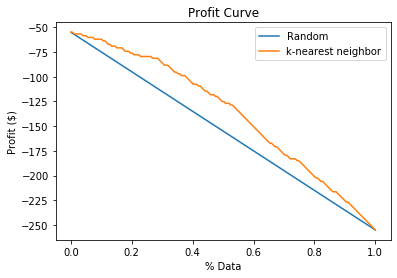

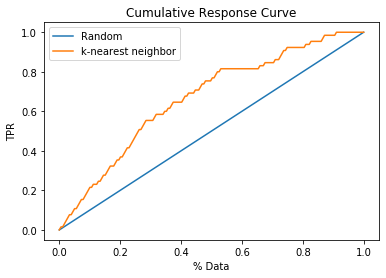

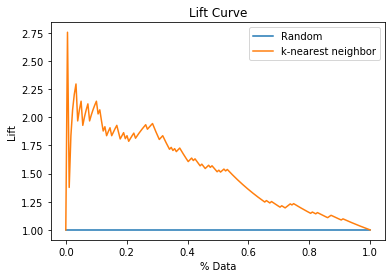

In [98]:
#KNN (without ROC)
kNN=KNeighborsClassifier()
kNN.fit(X_train,np.ravel(Y_train))
conf1 = confusion_matrix(kNN.predict(X_test), Y_test)
print(conf1)
TN, FN, FP, TP = conf1.ravel()
print(f"Expected profit on THIS dataset: {np.sum(conf1*profit)/len(Y_train)}")

TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
TNR = TN/(TN + FP)
print(f"Expected profit for comparison: {pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)}")
knnProfit, knnCumResp, knnLift,knnAUC = curves_knn(kNN,X_test,Y_test)
print("knnAUC: " + str(knnAUC))
plot_curves_knn(knnProfit, knnCumResp, knnLift, "k-nearest neighbor")

[[100  18]
 [ 14  47]]
Expected profit on THIS dataset: -27.542134831460675
Expected profit for comparison: -79.56140350877192
dtcAUC: 0.822402159244265


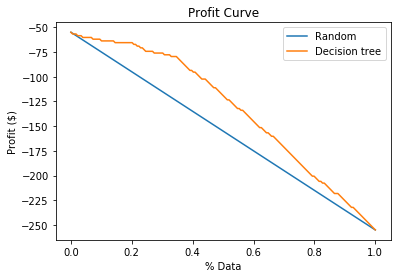

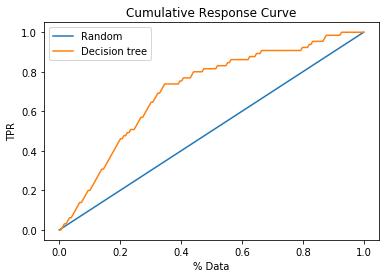

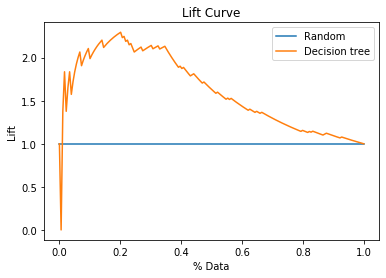

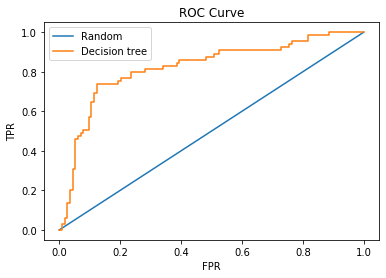

In [99]:
#Decision Tree
dtc = tree.DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train,np.ravel(Y_train))
conf2 = confusion_matrix(dtc.predict(X_test), Y_test)
print(conf2)
TN, FN, FP, TP = conf2.ravel()
print(f"Expected profit on THIS dataset: {np.sum(conf2*profit)/len(Y_train)}")

TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
TNR = TN/(TN + FP)
print(f"Expected profit for comparison: {pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)}")
dtcProfit, dtcCumResp, dtcLift, dtcROC, dtcAUC = curves(dtc,X_test,Y_test)
print("dtcAUC: " + str(dtcAUC))
plot_curves(dtcProfit, dtcCumResp, dtcLift, dtcROC, "Decision tree")

[[102  20]
 [ 12  45]]
Expected profit on THIS dataset: -29.171348314606742
Expected profit for comparison: -76.05263157894737
rfcAUC: 0.8688259109311739


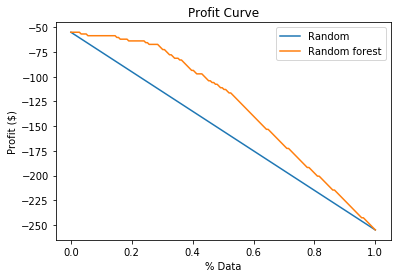

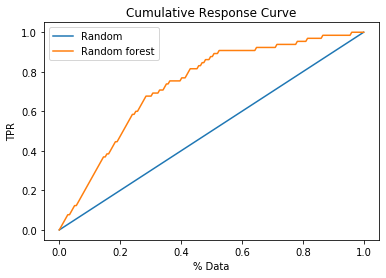

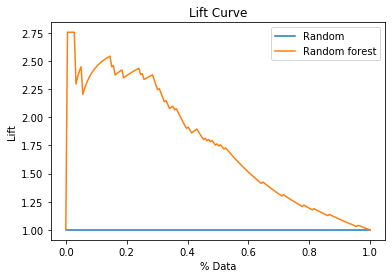

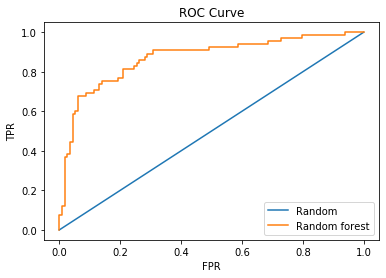

In [100]:
#Random Forest
random_forest = ensemble.RandomForestClassifier(criterion='entropy',n_estimators=10)
random_forest.fit(X_train,np.ravel(Y_train))
conf3 = confusion_matrix(random_forest.predict(X_test), Y_test)
print(conf3)
TN, FN, FP, TP = conf3.ravel()
print(f"Expected profit on THIS dataset: {np.sum(conf3*profit)/len(Y_train)}")

TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
TNR = TN/(TN + FP)
print(f"Expected profit for comparison: {pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)}")
rfcProfit, rfcCumResp, rfcLift, rfcROC, rfcAUC = curves(random_forest,X_test,Y_test)
print("rfcAUC: " + str(rfcAUC))
plot_curves(rfcProfit, rfcCumResp, rfcLift, rfcROC, "Random forest")

W1112 12:42:06.500719 15764 deprecation.py:506] From C:\Users\Srujan\Anaconda3\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1112 12:42:06.969525 15764 deprecation.py:323] From C:\Users\Srujan\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[[103  18]
 [ 11  47]]
Expected profit on THIS dataset: -27.921348314606742
Expected profit for comparison: -74.2982456140351
nnetAUC: 0.8994601889338736


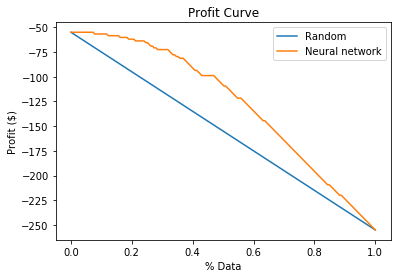

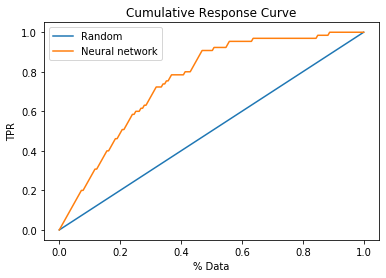

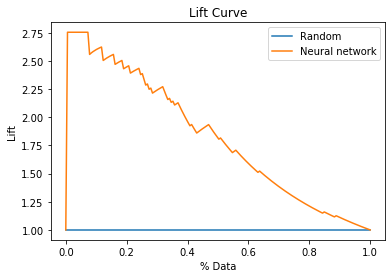

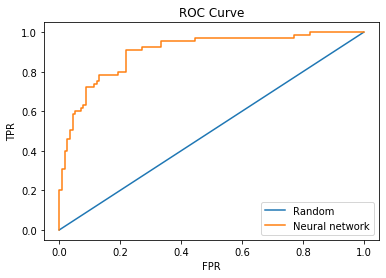

In [101]:
#Neural networks
model = keras.Sequential()

# layers
model.add(keras.layers.Dense(9, kernel_initializer = 'uniform', activation = 'relu', input_dim = 7))
model.add(keras.layers.Dense(9, kernel_initializer = 'uniform', activation = 'relu'))
model.add(keras.layers.Dense(5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(keras.layers.Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, np.ravel(Y_train), epochs = 500, batch_size = 200, validation_split = 0.5, verbose = 0)
conf4 = confusion_matrix(model.predict(X_test) > 0.5, Y_test)
print(conf4)
TN, FN, FP, TP = conf4.ravel()
print(f"Expected profit on THIS dataset: {np.sum(conf4*profit)/len(Y_train)}")

TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
TNR = TN/(TN + FP)
print(f"Expected profit for comparison: {pp*(TPR*TPp + FNR*FNp)+pn*(FPR*FPp + TNR*TNp)}")
nnProfit, nnCumResp, nnLift, nnROC, nnAUC = curves(model,X_test,Y_test)
print("neuralNetworkAUC: " + str(nnAUC))
plot_curves(nnProfit, nnCumResp, nnLift, nnROC, "Neural network")